<h1> Making an predictive model using Decision Tree</h1>
In deze jupyter notebook file, worden de de decision tree gemaakt. 
Dit wordt gedaan om de onderzoeksvraag van mijn thesis te kunnen beantwoorden:
To what extent can support vector machine, randomforest tree, or Gradient Boosting Machine contributeto predicting the demand for the specialist youth caresegments in Amsterdam?
Ook is dit nodig voor het beantwoorden van mijn sub vraen:
•Are there neighborhood socio-demographic characteristics which are predictive of the use of youth caresegments?
•Which of the tested models has the highest f1 score in predicting the youth care segment use?


<h3>Hier onder worden eerst de benodigde librabry geimporteerd</h3>

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

Om de sub onderzoeks vraag: Which of the tested models has the highest f1-score in predicting the youth care segment use? Waarom we voor deze score hebben gekozen, kan gelezen worden onder het kopje "model eveluation".

Ook maken we een aantal variabele hier aan om de code zo gestructuurd mogelijk te houden. Waarom deze nodig zijn, valt te lezen in het kopje "model making'

In [2]:
# Defining Def inorder to calcualte some metrics
def calculateMetrics(model):
        y_predicted = model.predict(X_test)
        print(model)
        print ("F1 score")
        print(f1_score(y_test, y_predicted, average='micro'))
        
# Some variables for making 
param_dict = { 
    'criterion': ['gini', 'entropy'],
    'max_depth': range(4,26,4),
    'min_samples_split': range(1,10,2),
    'min_samples_leaf': range(1,5)
}

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=42)



<h3> Laad de data in, die gemaakt is uit de andere jupyter notebook file</h3

In [3]:
df = pd.read_pickle("C:\\VERTROUWELIJK\\final_dataSet.pkl")

Split the data in indepentend variable an dependent variable. Also get dummies from the binary values in the data set. 

In [4]:
X = df.drop(['Voorziening'], axis=1)
X_encoded = pd.get_dummies(X, columns=['Geslacht'])
y = df['Voorziening'].copy()

Make test and train set. Waarom dit nodig is, zie "making model"

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,random_state=42)

 <h4>Make the first DecisionTree</h4>
 and fit this to get the scores. Dit is nodig om alle onderzoeksvragen mee te bentwoorden

In [6]:
# Make the first DecisionTree, and fit this to get the scores.
clf_dt = DecisionTreeClassifier(random_state = 42)
print(clf_dt)
scores = cross_val_score(clf_dt, X_train, y_train, cv=5, scoring='f1_micro')
score = mean(scores)
print("f1_score: %.2f%%" % (score * 100.0))
std_scores = scores.std()
print("f1_score STD")
print(std_scores)

DecisionTreeClassifier(random_state=42)
f1_score: 51.21%
f1_score STD
0.011886486707129088


Zoals gezegd, de data is erg imbalanced. Daarom maken we een decision tree with random undersampling

In [7]:
steps = [('under', RandomUnderSampler()), ('model', DecisionTreeClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=100, n_repeats=5, random_state=42)
scores = cross_val_score(pipeline, X_encoded, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
# calculate the mean and STD of all these models. 
print('F1 Score: %.3f' % score)
std_scores = scores.std()
print("f1_score STD")
print(std_scores)

C:\Users\jopho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 68 members, which is less than n_splits=100.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\jopho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 68 members, which is less than n_splits=100.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\jopho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 68 members, which is less than n_splits=100.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\jopho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 68 members, which is less than n_splits=100.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\jopho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarnin

F1 Score: 0.314
f1_score STD
0.037138673316640156


<h4>Prune the model</h4>
Na het vergelijken van de twee modellen, heeft het model met de normale data set de hoogste F1 score, hier na gaan we het model nog prunen. Zie Making Model in de thesis 

In [8]:
grid = GridSearchCV(DecisionTreeClassifier(random_state = 42),
                   param_grid=param_dict,
                   cv=cv_method,
                    scoring='f1_micro',
                   verbose=1,
                   n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 15 folds for each of 240 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2466 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 3216 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 17.3min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(4, 26, 4),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10, 2)},
             scoring='f1_micro', verbose=1)

In [9]:
# Print the best parameters after doing the gridsearch
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

In [10]:
# Print the std for this gridSearch
grid.cv_results_['std_test_score'][grid.best_index_]

0.009370216505111823

In [11]:
# get the best F1 score, coming from the gridSearch.
grid.best_score_

0.5737926393028627

In order to visulation the gridsearch, we needed to make an figure. This can be seen in Figure X in the thesis. 

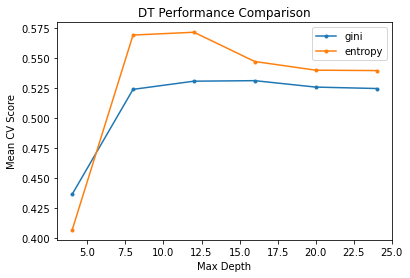

In [14]:
results_DT = pd.DataFrame(grid.cv_results_['params'])
results_DT['test_score'] = grid.cv_results_['mean_test_score']
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.savefig('DT Performance Comparison.png')
plt.show()